In [5]:
ignorepip = """!pip install 'transformers[torch]'
#!pip install datasets
#!pip install mdanalysis
#!pip install ax-platform
#!pip install -q git+https://github.com/ORNL/affinity_pred.git"""

#INSTALL THESE IF YOU DO NOT HAVE THEM PRE-INSTALLED

In [12]:
import random
import numpy as np
import pandas as pd
np.object = object
np.bool = bool
np.int = int
import matplotlib.pyplot as plt
import torch
#from torch.utils.data import Dataset
from datasets import load_dataset, Dataset
import datasets
from transformers import AutoTokenizer, Trainer
from transformers import EvalPrediction
from transformers import TrainingArguments

from huggingface_hub import hf_hub_download

map_location=torch.device('cpu')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

import pandas as pd
import numpy as np
import re


# the transformer model
from affinity_pred.model import EnsembleSequenceRegressor

# the Bayesian optimization package
from ax import optimize, ChoiceParameter, RangeParameter
from ax.service.ax_client import AxClient, ObjectiveProperties

# Code that identifies binding residues on protein
from get_close_resids import binding_resids

import warnings
# Filter out the specific FutureWarning related to the `device` argument in transformers
warnings.filterwarnings("ignore", message="The `device` argument is deprecated and will be removed in v5 of Transformers.", category=FutureWarning, module="transformers.modeling_utils")



In [10]:
class predictor():
    seq_model_name = "Rostlab/prot_bert_bfd"
    seq_tokenizer = AutoTokenizer.from_pretrained(seq_model_name, do_lower_case=False)
    smiles_model_name = 'mossaic-candle/regex-gb-2021'
    smiles_tokenizer =  AutoTokenizer.from_pretrained(smiles_model_name)
    # the maximum length of a protein seqeuence (for inference)
    max_seq_length=512
    # the maximum length of a SMILES sequence
    max_smiles_length=256
    trainer = ""
    mod = ""
    def compute_metrics(p: EvalPrediction):
        preds_list, out_label_list = p.predictions, p.label_ids

        return {
            "mse": mean_squared_error(out_label_list, preds_list),
            "mae": mean_absolute_error(out_label_list, preds_list),
            "spearman_rho": spearmanr(out_label_list, preds_list).correlation,
        }

    def __init__(self):
        #self.testseq = testseq
        self.trainer = Trainer(
            model_init=self.model_init,                  # the instantiated Transformers model to be trained
            compute_metrics = self.compute_metrics,        # evaluation metric
            args=TrainingArguments(per_device_eval_batch_size=1, # reduce if running out of memory
                                   output_dir='results'),
                                   )
    def expand_seqs(self,seqs):
        """expand a FASTA sequence, fixing by removing U,Z,O,B with X"""
        input_fixed = ["".join(seq.split()) for seq in seqs]
        input_fixed = [re.sub(r"[UZOB]", "X", seq) for seq in input_fixed]
        return [list(seq) for seq in input_fixed]

    def encode(self,item,tolist=False):
        """encodes a {seq:"",smiles/smiles_can:""}
        for use in the model
        """
        seq_encodings = self.seq_tokenizer(self.expand_seqs(item['seq'])[0],
                                      truncation=True,
                                      padding='max_length',
                                      max_length=self.max_seq_length,
                                      is_split_into_words=True)

        # use RDkit canonical SMILES
        if 'smiles_can' in item:
            smiles = item['smiles_can'][0]
        else:
            smiles = item['smiles'][0]

        smiles_encodings = self.smiles_tokenizer(smiles,
                                            padding='max_length',
                                            truncation=True,
                                            max_length=self.max_smiles_length)

        # concatenate the two different inputs
        if tolist:
            item['input_ids'] = [torch.cat([torch.tensor(seq_encodings['input_ids']),
                                        torch.tensor(smiles_encodings['input_ids'])]).tolist()]
            item['attention_mask'] = [torch.cat([torch.tensor(seq_encodings['attention_mask']),
                                        torch.tensor(smiles_encodings['attention_mask'])]).tolist()]
        else:
            item['input_ids'] = [torch.cat([torch.tensor(seq_encodings['input_ids']),
                                            torch.tensor(smiles_encodings['input_ids'])])]
            item['attention_mask'] = [torch.cat([torch.tensor(seq_encodings['attention_mask']),
                                        torch.tensor(smiles_encodings['attention_mask'])])]
        return item

    def model_init(self):
        """
        loads the model out from huggingface
        """
        model = EnsembleSequenceRegressor(self.seq_model_name, self.smiles_model_name, max_seq_length=self.max_seq_length)

        # select one of the following ensemble members
        model_name = 'regex_1'
        #model_name = 'regex_2'
        #model_name = 'regex_3'
        #model_name = 'regex_4'
        #model_name = 'regex_5'

        # download the weights
        fn = hf_hub_download(repo_id="jglaser/affinity_pred_{}".format(model_name), filename='pytorch_model.bin')

        checkpoint = torch.load(fn,map_location=torch.device('cpu'))
        #get rid of the following keys: seq_model.embeddings.position_ids and smiles_model.embeddings.position_ids
        # as they are not supported in transformers>4.30.2 (the author trained on older version of transformers)
        rchck = {}
        for key in checkpoint.keys():
            if key in ['seq_model.embeddings.position_ids','smiles_model.embeddings.position_ids']:
                pass
            else:
                rchck.update({key:checkpoint[key]})
        model.load_state_dict(rchck)
        return model

    class AffinityDataset(Dataset):
        def __init__(self, dataset):
            self.dataset = dataset

        def __getitem__(self, idx):
            item = self.dataset[idx]

            #affinity = item['neg_log10_affinity_M']
            affinity = item['affinity']
            item['labels'] = float(affinity)

            # drop the non-encoded input
            item.pop('smiles')
            item.pop('smiles_can')
            item.pop('seq')
            item.pop('neg_log10_affinity_M')
            item.pop('affinity_uM')
            item.pop('affinity')
            return item

        def __len__(self):
            return len(self.dataset)




    def preloaded_to_oneoff(item):
        rdict = {'seq':item['seq'],"smiles":item['smiles'],'affinity_uM':0,'neg_log10_affinity_M':0,'affinity':0}
        return Dataset.from_pandas(pd.DataFrame.from_dict(encode(rdict,tolist=True)))
    def predict(self,testseq):
        item = self.encode(testseq,tolist=True)
        pdf = pd.DataFrame.from_dict(item)
        myds = Dataset.from_pandas(pdf)
        return self.trainer.predict(myds)

#FINISH SETUP THINGS

#loading the initial model will take some time, so keep it in memory until job is done
predictor = predictor()

#FEED THE y.predictions (from the docs are -log_10(muaffinity)) to the BO. INPUT INTO PREDICTOR.predict is a dict of {'seq':"FASTA(?) SEQ", "smiles":"SMILES OF A SMALL LIGAND"}


Some weights of BertModel were not initialized from the model checkpoint at mossaic-candle/regex-gb-2021 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define protein, target ligand, and BO parameters

In [15]:
# Define starting protein, ligand, and the residues that bind to the ligand
fasta_str_f = 'MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW'
smiles_fentanyl = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"

pdb_file = '5tzo.pdb'
ligand_resname = '7V7'
rcut = 5.0 #angstroms

binding_residues = binding_resids(pdb_file,ligand_resname,rcut)
#binding residues below were obtained by visual inspection
#binding_residues = [x - 55 + 17 for x in [7,9,35,36,37,63,64,65,67,69,71,80,82,89,90,91,92,108,110,111,112,116,117,118,120,125,127,129,131,166,172,173,174]]
#print(binding_residues)

axbo_params=[
    {
        "name": "position",
        "type": "choice",
        "values": list(binding_residues),
        "value_type": "int"
    },
    {
        "name": "mutation",
        "type": "choice",
        "values": ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"],
    }
]

Do 'memoryless' BO (i.e. keep the best **single** mutation)

In [36]:
def evaluate_protein_BA(fasta_seq, target_smiles, predictor_obj):
    testseq = {'seq': [fasta_seq], 'smiles': [target_smiles]}
    # Get predictions from the predictor
    prediction_result = predictor_obj.predict(testseq)
    #print("Prediction Result:", prediction_result)
    score_bo = prediction_result.predictions * -1

    return score_bo

def evaluate_mutation_BA(parameters, fasta,  target_smiles, predictor_obj):
    position = int(parameters["position"])
    mutation = parameters["mutation"]

    new_fasta = list(fasta[:])

    # Perform single-point mutation
    new_fasta[position] = mutation

    # Convert list to string to form the sequence
    mutated_sequence = ''.join(new_fasta)
    score_bo = evaluate_protein_BA(mutated_sequence, target_smiles, predictor_obj)
    print('Mutated:', mutation, position, "KD (uM):", 10 ** (score_bo), "Predictions:", score_bo, "Mutated Sequence:", mutated_sequence)
    return score_bo


# evaluate_for_opt = partial(evaluate_mutation_BA, fasta = fasta_str_f, target_smiles = smiles_fentanyl, predictor_obj = predictor)
def evaluate_for_opt(parameters):
  return evaluate_mutation_BA(parameters, fasta_str_f, smiles_fentanyl, predictor)

print('\033[95m\033[1m\033[1m ----- /\ ----/ Starting Bayesian Protein Optimization \---- /\ ----- \033[0m')

#Get the original BA
testseq = {'seq': [fasta_str_f],  'smiles': [smiles_fentanyl]}  # Example SMILES, adjust as needed
# Get predictions from the predictor
#prediction_result = predictor.predict(testseq)
##print("Prediction Result:", prediction_result)
#score = 10 ** (prediction_result.predictions * -1)
print(fasta_str_f)
print('Orginal KD (uM): ', score)

best_parameters, values, experiment, model = optimize(
    parameters=axbo_params,
    evaluation_function=evaluate_for_opt,
    objective_name='Decrease KD',
    minimize=False,
    total_trials=50
)

print(f"Best parameters: {best_parameters}")
#print(f"Best objective value: {values[0]['objective']}")


/nfs/ai/chemical-diffuser/venv/lib/python3.8/site-packages/ax/core/parameter.py:517: UserWarning: `is_ordered` is not specified for `ChoiceParameter` "position". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.
  warn(
/nfs/ai/chemical-diffuser/venv/lib/python3.8/site-packages/ax/core/parameter.py:517: UserWarning: `sort_values` is not specified for `ChoiceParameter` "position". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
  warn(
[INFO 03-28 23:55:49] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter mutation. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/nfs/ai/chemical-diffuser/venv/lib/python3.8/site-packages/ax/

 ----- /\ ----/ Starting Bayesian Protein Optimization \---- /\ ----- 
MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW
Orginal KD (uM):  1.7678596712321373


[INFO 03-28 23:55:50] ax.service.managed_loop: Running optimization trial 2...


Mutated: D 67 KD (uM): 2.0393045941919623 Predictions: 0.3094820976257324 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALADVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:50] ax.service.managed_loop: Running optimization trial 3...


Mutated: W 120 KD (uM): 0.7484311260354936 Predictions: -0.12584815919399261 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGWRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:50] ax.service.managed_loop: Running optimization trial 4...


Mutated: N 92 KD (uM): 1.7166640671695816 Predictions: 0.23468531668186188 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGNYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:50] ax.service.managed_loop: Running optimization trial 5...


Mutated: I 71 KD (uM): 0.7330114690386282 Predictions: -0.13488923013210297 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWIRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:51] ax.service.managed_loop: Running optimization trial 6...


Mutated: H 174 KD (uM): 1.5117931363936772 Predictions: 0.17949236929416656 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYHSSGSSNVTVW


[INFO 03-28 23:55:51] ax.service.managed_loop: Running optimization trial 7...


Mutated: D 174 KD (uM): 1.572826054525452 Predictions: 0.1966806948184967 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYDSSGSSNVTVW


[INFO 03-28 23:55:52] ax.service.managed_loop: Running optimization trial 8...


Mutated: D 7 KD (uM): 1.3377070394024047 Predictions: 0.12636101245880127 Mutated Sequence: MSTDYWLDFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:53] ax.service.managed_loop: Running optimization trial 9...


Mutated: D 173 KD (uM): 1.6679809849373703 Predictions: 0.22219109535217285 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGDQSSGSSNVTVW


[INFO 03-28 23:55:53] ax.service.managed_loop: Running optimization trial 10...


Mutated: D 108 KD (uM): 1.8269792773342433 Predictions: 0.26173362135887146 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYDTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:54] ax.service.managed_loop: Running optimization trial 11...


Mutated: D 80 KD (uM): 1.7099127987149352 Predictions: 0.23297396302223206 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYDVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:55] ax.service.managed_loop: Running optimization trial 12...


Mutated: N 166 KD (uM): 1.602733109704195 Predictions: 0.20486120879650116 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYNVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:56] ax.service.managed_loop: Running optimization trial 13...


Mutated: N 7 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


[INFO 03-28 23:55:57] ax.service.managed_loop: Running optimization trial 14...


Mutated: H 7 KD (uM): 1.4940536437444372 Predictions: 0.17436619102954865 Mutated Sequence: MSTDYWLHFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


KeyboardInterrupt: 

Compare to random mutations/rudimentary genetic algorithm and plot scoring function over iterations.

In [39]:
best_objectives = np.array(
    [[trial.objective_mean for trial in experiment.trials.values()]]
)
rand_objectives = []
def random_mutations(params, inseq,maxloops=100):
  valpos = params[0]['values']
  valmut = params[1]['values']
  newseq = inseq
  for round in range(maxloops):
    randpos = random.randint(0,len(valpos)-1)
    randmut = random.randint(0,len(valmut)-1)
    newseq = newseq[:randpos]+valmut[randmut] + newseq[randpos+1:]
    ts = {'seq': [newseq], 'smiles': [smiles_fentanyl]} #SMILES of fentanyl
    #print(round)
    score = (predictor.predict(ts).predictions)*-1
    print(score)
    rand_objectives.append(score)
    #print(rand_objectives)
    newseq = inseq #reset to the original inseq to match what the BO is optimizing with
random_mutations(axbo_params,fasta_str_f)


-0.09802576899528503


0.09214495122432709


0.21262018382549286


0.21732273697853088


0.2526121735572815


0.26281630992889404


0.13657549023628235


0.1435823142528534


0.21356983482837677


0.274383008480072


0.15367504954338074


0.24454189836978912


0.22621896862983704


0.1582115888595581


-0.09802576899528503


0.22905996441841125


-0.24627652764320374


0.2578401565551758


-0.0704164206981659


0.04823090136051178


0.20674920082092285


0.13958565890789032


0.25770464539527893


0.26361000537872314


0.24980250000953674


0.22574767470359802


0.3322741389274597


0.23953795433044434


0.23718714714050293


0.24744778871536255


0.14527985453605652


0.15177057683467865


0.2183953821659088


0.06228563189506531


0.005122154951095581


0.28020429611206055


0.1677219718694687


0.04507449269294739


-0.3544921875


0.06399014592170715


0.22820182144641876


-0.06880559027194977


0.27168309688568115


0.28565266728401184


0.2685624361038208


-0.3578532040119171


0.24744778871536255


0.2472122311592102


0.07309629023075104


-0.00909695029258728


0.2057197391986847


0.23162224888801575


0.274383008480072


0.2225569784641266


0.24744778871536255


0.13290539383888245


0.288983017206192


0.23605038225650787


0.2510915994644165


0.24409140646457672


0.20014309883117676


0.1878720223903656


0.22273772954940796


0.07990372180938721


0.21576115489006042


0.22575533390045166


0.19485409557819366


0.2050567865371704


-0.04071526229381561


0.30405333638191223


-0.3467831015586853


-0.04363928735256195


0.04892371594905853


0.19305822253227234


0.08741286396980286


0.2606697976589203


0.24613437056541443


0.20014309883117676


0.07456758618354797


0.21133995056152344


0.10676875710487366


0.2202855348587036


0.16653667390346527


0.22818121314048767


0.18670019507408142


-0.2242196649312973


0.1139879822731018


0.09214495122432709


0.16843849420547485


0.2793005108833313


0.17994004487991333


0.28020429611206055


-0.25470906496047974


0.21774128079414368


-0.06880559027194977


0.2009955644607544


0.20423759520053864


-0.04085734486579895


0.24024698138237


0.28565266728401184


In [ ]:
gascores = []
bestmuts = []
from copy import deepcopy
def cityga(seq,maxrounds=2,pop=10):
  smi = smiles_fentanyl
  #smi = "C[C@H]1CN(CC[C@@]1(C)c2cccc(c2)O)C[C@H](C(C)C)NC(=O)[C@H]3Cc4ccc(cc4CN3)O"
  def mutt(params, inseq):
    valpos = params[0]['values']
    valmut = params[1]['values']
    newseq = inseq
    for round in range(maxrounds):
      randpos = random.randint(0,len(valpos)-1)
      randmut = random.randint(0,len(valmut)-1)
      newseq = newseq[:randpos]+valmut[randmut] + newseq[randpos+1:]
      return newseq
  def breed(seq1,seq2,childn=10):
    childs = []
    for i in range(childn):
      splitpt = random.randint(0,len(seq2))
      childs.append(seq1[:splitpt]+seq2[splitpt:])
    return childs
  initpop = [seq for i in range(pop)]
  initmut = [mutt(params,seq) for seq in initpop]
  print([initmut[x]==initpop[x] for x in range(len(initmut)) ])
  for round in range(maxrounds):
    if round%5==0:
      print(round)
    scores = [predictor.predict({"seq":[mut,],"smiles":[smi,]}).predictions*-1 for mut in initmut]
    sc = deepcopy(scores)
    bestid = scores.index(max(sc))
    sc.pop(bestid)
    nextbestid = scores.index(max(sc))
    initmut = breed(initmut[bestid],initmut[nextbestid])
    initmut = [mutt(params,seq) for seq in initmut]
    gascores.append(scores[bestid])
    bestmuts.append(initmut[bestid])

cityga(fasta_str_f,maxrounds=50)

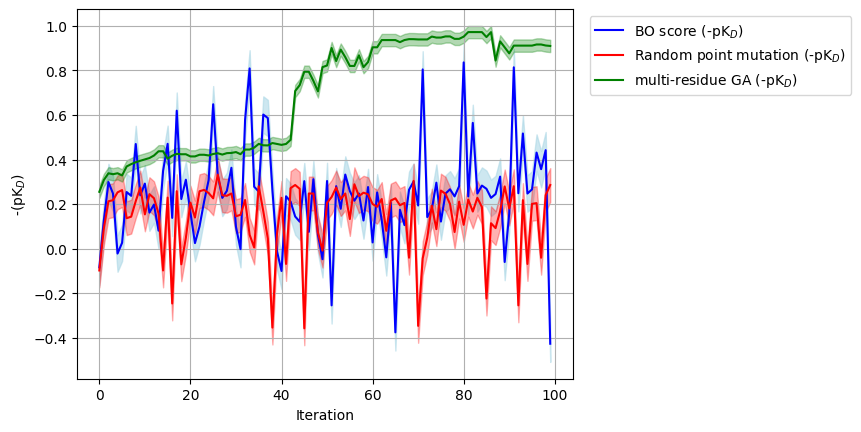

Additive BO: allow model to save mutations that yield proteins with a higher binding affinity as the optimization progresses.

In [49]:
def additive_BO(axclient, fasta_init, target_smiles="CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3", predictor_obj=predictor, max_mutations=3, max_bo_steps=100, max_bo_loops=10,early_break=True):

    # get binding affinity of starting protein
    initial_score = evaluate_protein_BA(fasta_init, target_smiles, predictor_obj)
    print("Initial score = ", initial_score)

    print("Starting BO loop:")

    # initialise variables for BO search
    nmutations = 0
    ntries = 0

    ref_fasta = fasta_init[:]
    ref_score = initial_score
    accepted_mutations = {'position':[], "mutation": [], 'scores':[]}

    # prepare to save output from each BO iteration if early_break=False (see below for explanation of `early_break`)
    if not early_break:
      mutations = np.zeros((max_mutations, max_bo_steps), dtype='str')
      positions = np.zeros((max_mutations, max_bo_steps), dtype='int')
      scores = np.zeros((max_mutations, max_bo_steps), dtype='float')

    # BO search loop starts here
    while nmutations < max_mutations and ntries < max_bo_loops:
      print(f'~~~~~ Starting BO loop nb {ntries+1} ~~~~~')
      for i in range(max_bo_steps):
        new_params, itrial = axclient.get_next_trial() #get new mutation
        new_score = evaluate_mutation_BA(new_params,ref_fasta,target_smiles,predictor_obj) #evaluate new mutation
        axclient.complete_trial(itrial, raw_data=new_score) #update model

        position = int(new_params["position"])
        mutation = new_params["mutation"]

        if new_score > ref_score and early_break:
          # `early_break=True` interrupts the BO search as soon as a better candidate is found
          # if we have something better than the initial protein, interrupt BO, and save changes
          print(f'******** Mutation accepted! ********')
          new_fasta = list(ref_fasta[:])
          new_fasta[position] = mutation
          ref_fasta = ''.join(new_fasta)
          nmutations += 1
          accepted_mutations['position'].append(position)
          accepted_mutations['mutation'].append(mutation)
          break

        if not early_break:
          # if all BO trials are to be run, save output from each trial
          positions[nmutations,i] = position
          mutations[nmutations,i] = mutation
          scores[nmutations,i] = new_score


      if not early_break:
        # find the best scoring mutation: if better than current FASTA, save changes
        ibest = np.argmax(scores[ntries,:])
        best_score = scores[nmutations,ibest]
        if best_score > ref_score:
          print(f'******** Mutation accepted! ********')
          best_pos = positions[nmutations,ibest]
          best_mut = mutations[nmutations,ibest]
          print(f"Mutate site {best_pos}: {best_mut}")
          new_fasta = list(ref_fasta[:])
          new_fasta[best_pos] = best_mut
          ref_fasta = ''.join(new_fasta)
          nmutations += 1
          accepted_mutations['position'].append(position)
          accepted_mutations['mutation'].append(mutation)

      ntries += 1

    # do final scoring
    print("\nDone with BO loops! Evaluating final sequence...")
    final_score = evaluate_protein_BA(ref_fasta, target_smiles, predictor_obj)
    print("Final score = ", final_score)

    # output results; if early_break=False, also return each BO trial's binding score
    if early_break:
      return ref_fasta, final_score, accepted_mutations
    else:
      return ref_fasta, final_score, accepted_mutations, scores




# set up BO run
axclient = AxClient(verbose_logging=False)

axclient.create_experiment(
    name = "5TZO binding affinity",
    parameters = axbo_params,
    objectives = {"neg pKD": ObjectiveProperties(minimize=False)}
)

# run the BO
final_fasta, final_score, mutations, scores = additive_BO(axclient,fasta_str_f,smiles_fentanyl, early_break=False,max_bo_steps=100)


/nfs/ai/chemical-diffuser/venv/lib/python3.8/site-packages/ax/core/parameter.py:517: UserWarning: `is_ordered` is not specified for `ChoiceParameter` "position". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.
  warn(
/nfs/ai/chemical-diffuser/venv/lib/python3.8/site-packages/ax/core/parameter.py:517: UserWarning: `sort_values` is not specified for `ChoiceParameter` "position". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
  warn(
[INFO 03-29 00:32:55] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter mutation. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/nfs/ai/chemical-diffuser/venv/lib/python3.8/site-packages/ax/

Initial score =  0.24744778871536255
Starting BO loop:
~~~~~ Starting BO loop nb 1 ~~~~~


Mutated: R 172 KD (uM): 0.6386935302840012 Predictions: -0.1947074830532074 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATARYQSSGSSNVTVW


Mutated: L 92 KD (uM): 0.7219413399169207 Predictions: -0.14149808883666992 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGLYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 127 KD (uM): 2.044673244140254 Predictions: 0.3106239140033722 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQAWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 65 KD (uM): 3.9982296492183913 Predictions: 0.6018677353858948 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAPALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 166 KD (uM): 1.6675744696130825 Predictions: 0.22208523750305176 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYKVMATAGYQSSGSSNVTVW


Mutated: P 174 KD (uM): 1.1131033554749286 Predictions: 0.046535491943359375 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYPSSGSSNVTVW


Mutated: P 63 KD (uM): 1.965696871607265 Predictions: 0.2935165464878082 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWPALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 67 KD (uM): 2.033777394252436 Predictions: 0.3083034157752991 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALAPVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 64 KD (uM): 1.4493463507706497 Predictions: 0.16117218136787415 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGPLALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 89 KD (uM): 1.6022335881241483 Predictions: 0.20472583174705505 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARPTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 35 KD (uM): 0.7153015686763768 Predictions: -0.14551082253456116 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSPVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 65 KD (uM): 1.320947435528325 Predictions: 0.12088553607463837 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAAALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 69 KD (uM): 2.6993686211147074 Predictions: 0.43126219511032104 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVPWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 71 KD (uM): 2.1810448249426964 Predictions: 0.33866459131240845 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWPRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 112 KD (uM): 1.8606048760851284 Predictions: 0.26965415477752686 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRANAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 166 KD (uM): 1.682440987584884 Predictions: 0.22593984007835388 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYAVMATAGYQSSGSSNVTVW


Mutated: A 92 KD (uM): 1.8349781480936518 Predictions: 0.2636308968067169 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGAYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 131 KD (uM): 1.4412566532697688 Predictions: 0.1587413251399994 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVKQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 89 KD (uM): 0.33807730514928996 Predictions: -0.47098398208618164 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARKTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 7 KD (uM): 1.1542121240281251 Predictions: 0.06228563189506531 Mutated Sequence: MSTDYWLAFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 174 KD (uM): 1.364470882566246 Predictions: 0.13496427237987518 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYNSSGSSNVTVW


Mutated: N 131 KD (uM): 1.4545248890935547 Predictions: 0.1627211570739746 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVNQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 92 KD (uM): 1.7166640671695816 Predictions: 0.23468531668186188 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGNYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 65 KD (uM): 6.376652179252319 Predictions: 0.8045927286148071 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGANALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 63 KD (uM): 1.385787665594276 Predictions: 0.14169669151306152 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWNALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 65 KD (uM): 6.443446267829658 Predictions: 0.8091182112693787 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGADALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 65 KD (uM): 1.45316572259868 Predictions: 0.16231514513492584 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGACALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 65 KD (uM): 3.6686017618637385 Predictions: 0.5645005702972412 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAQALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 65 KD (uM): 4.447887374513486 Predictions: 0.6481537818908691 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAEALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 65 KD (uM): 6.8561952005624756 Predictions: 0.836083173751831 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 65 KD (uM): 2.1419507161634033 Predictions: 0.33080947399139404 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAHALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 65 KD (uM): 1.6897737618017363 Predictions: 0.22782856225967407 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAIALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 65 KD (uM): 1.8964404080814137 Predictions: 0.27793920040130615 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAMALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 65 KD (uM): 1.8045693812513426 Predictions: 0.2563735842704773 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAFALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 65 KD (uM): 3.8564252600580073 Predictions: 0.5861849188804626 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGASALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 65 KD (uM): 1.837582899248184 Predictions: 0.26424694061279297 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGATALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 65 KD (uM): 0.9755752086576203 Predictions: -0.010739244520664215 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAWALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 65 KD (uM): 0.7937489205177347 Predictions: -0.1003168523311615 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAYALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 67 KD (uM): 1.2576009915631463 Predictions: 0.09954287111759186 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALAGVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 65 KD (uM): 1.3232610372263467 Predictions: 0.12164552509784698 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAVALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 65 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 65 KD (uM): 3.7792117029392727 Predictions: 0.5774012207984924 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAKALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 65 KD (uM): 4.161730569844946 Predictions: 0.6192739605903625 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGARALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 69 KD (uM): 6.516455810842995 Predictions: 0.8140114545822144 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVDWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 69 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 67 KD (uM): 2.0393045941919623 Predictions: 0.3094820976257324 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALADVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 69 KD (uM): 3.2879807697357966 Predictions: 0.5169292688369751 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVNWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 69 KD (uM): 2.104889120978559 Predictions: 0.32322922348976135 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVEWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 69 KD (uM): 1.7729293908866801 Predictions: 0.24869143962860107 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVSWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 67 KD (uM): 1.37413352274851 Predictions: 0.13802893459796906 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALANVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 63 KD (uM): 1.7182057214607713 Predictions: 0.23507516086101532 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWDALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 69 KD (uM): 1.8446818448284277 Predictions: 0.2659214735031128 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVQWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 69 KD (uM): 1.8491109707289577 Predictions: 0.2669629752635956 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVHWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 69 KD (uM): 2.3067508586224372 Predictions: 0.36300069093704224 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVRWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 69 KD (uM): 2.05931488898746 Predictions: 0.31372275948524475 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVAWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 69 KD (uM): 1.9586621194953446 Predictions: 0.2919595241546631 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVKWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 69 KD (uM): 0.3741931202519127 Predictions: -0.42690420150756836 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVMWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 69 KD (uM): 2.767031467965897 Predictions: 0.44201409816741943 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVTWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 69 KD (uM): 2.273463223182374 Predictions: 0.3566879332065582 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVFWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 69 KD (uM): 0.9056505977518824 Predictions: -0.04303932189941406 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVIWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 69 KD (uM): 1.1050500391547855 Predictions: 0.0433819442987442 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVCWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 64 KD (uM): 1.4388908226612613 Predictions: 0.15802784264087677 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGDLALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 69 KD (uM): 2.0785441113252197 Predictions: 0.317759245634079 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVVWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 69 KD (uM): 1.9833937410566205 Predictions: 0.29740893840789795 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVWWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 69 KD (uM): 1.6708514971395296 Predictions: 0.22293785214424133 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVLWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 69 KD (uM): 3.045996237080337 Predictions: 0.48372936248779297 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVYWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 71 KD (uM): 4.626348244585608 Predictions: 0.6652383208274841 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWDRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 71 KD (uM): 1.7335916654333974 Predictions: 0.2389468103647232 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWNRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 71 KD (uM): 2.966723318928788 Predictions: 0.47227704524993896 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWERSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 71 KD (uM): 1.4197707434189741 Predictions: 0.15221822261810303 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWGRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 71 KD (uM): 1.7032686115751778 Predictions: 0.23128314316272736 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWSRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 71 KD (uM): 1.5767741011961816 Predictions: 0.19776947796344757 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWQRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 71 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 71 KD (uM): 1.6702995109733918 Predictions: 0.22279435396194458 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWRRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 64 KD (uM): 1.8161097952566816 Predictions: 0.25914210081100464 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGELALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 64 KD (uM): 1.7298370356973176 Predictions: 0.23800519108772278 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGNLALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 127 KD (uM): 2.0120322686180314 Predictions: 0.3036349415779114 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQDWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 64 KD (uM): 1.8270847179530894 Predictions: 0.2617586851119995 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGSLALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 112 KD (uM): 1.550023716987427 Predictions: 0.1903383433818817 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRDNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 67 KD (uM): 2.2350656369302406 Predictions: 0.34929028153419495 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALAEVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 67 KD (uM): 1.0586602952482984 Predictions: 0.024756625294685364 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALAQVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 9 KD (uM): 0.5562767837892941 Predictions: -0.25470906496047974 Mutated Sequence: MSTDYWLNFDDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 71 KD (uM): 1.6735163182923671 Predictions: 0.22362995147705078 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWFRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 71 KD (uM): 1.8145231301739453 Predictions: 0.25876250863075256 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWARSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 71 KD (uM): 1.9913363692763348 Predictions: 0.2991446256637573 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWKRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 63 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 71 KD (uM): 1.5643110839027645 Predictions: 0.1943231225013733 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWHRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 71 KD (uM): 2.525405625887219 Predictions: 0.40233114361763 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWYRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 71 KD (uM): 1.6123062178402212 Predictions: 0.20744752883911133 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWVRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 71 KD (uM): 1.2563306350176102 Predictions: 0.09910394996404648 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWWRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 80 KD (uM): 1.7099127987149352 Predictions: 0.23297396302223206 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYDVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 127 KD (uM): 1.9070155379416458 Predictions: 0.28035423159599304 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQEWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 120 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 82 KD (uM): 1.7678596712321373 Predictions: 0.24744778871536255 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 63 KD (uM): 1.8257754791889549 Predictions: 0.26144737005233765 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWRALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 63 KD (uM): 1.9026577821300703 Predictions: 0.27936068177223206 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWKALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 63 KD (uM): 1.7187839775403573 Predictions: 0.23522129654884338 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWEALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 71 KD (uM): 0.6476638544812551 Predictions: -0.18865033984184265 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWLRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 36 KD (uM): 1.717876909267851 Predictions: 0.23499204218387604 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFDVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 108 KD (uM): 1.8269792773342433 Predictions: 0.26173362135887146 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGALALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYDTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW
******** Mutation accepted! ********
Mutate site 65: G
~~~~~ Starting BO loop nb 2 ~~~~~


Mutated: N 127 KD (uM): 7.467804946626986 Predictions: 0.8731929659843445 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQNWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 125 KD (uM): 5.415829574152208 Predictions: 0.7336649894714355 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFNQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 129 KD (uM): 6.731675183581198 Predictions: 0.828123152256012 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWNVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 129 KD (uM): 6.883622934361979 Predictions: 0.8378170728683472 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWDVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 129 KD (uM): 5.9780104607814835 Predictions: 0.776556670665741 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWEVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 129 KD (uM): 7.130389172561856 Predictions: 0.8531132340431213 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWPVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 129 KD (uM): 5.643149909181074 Predictions: 0.7515215873718262 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWGVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 129 KD (uM): 6.8561952005624756 Predictions: 0.836083173751831 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 129 KD (uM): 4.7440473021330805 Predictions: 0.6761490106582642 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWRVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 129 KD (uM): 6.781368821057153 Predictions: 0.8313173651695251 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWQVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 129 KD (uM): 6.443689462970643 Predictions: 0.8091346025466919 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWKVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 129 KD (uM): 6.274951052972693 Predictions: 0.797610342502594 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWTVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 129 KD (uM): 3.6964465316431783 Predictions: 0.5677844285964966 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWFVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 129 KD (uM): 6.731850724435834 Predictions: 0.8281344771385193 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWHVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 129 KD (uM): 6.888195110168505 Predictions: 0.8381054401397705 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWAVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 129 KD (uM): 3.9942779597888713 Predictions: 0.6014382839202881 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWYVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 129 KD (uM): 3.3331656009447204 Predictions: 0.5228568911552429 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWVVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 129 KD (uM): 4.111217549115202 Predictions: 0.6139704585075378 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWWVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 129 KD (uM): 6.677753439117923 Predictions: 0.8246303796768188 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWCVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 129 KD (uM): 4.016694874738867 Predictions: 0.603868842124939 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWIVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 129 KD (uM): 4.367742241303158 Predictions: 0.6402570009231567 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWLVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 129 KD (uM): 5.255752162628287 Predictions: 0.7206348776817322 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWMVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 125 KD (uM): 3.3235777988576265 Predictions: 0.5216058492660522 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFPQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 125 KD (uM): 6.682116424060983 Predictions: 0.8249140381813049 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFSQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 125 KD (uM): 7.547989376337651 Predictions: 0.8778312802314758 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFGQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 125 KD (uM): 3.2450915389471393 Predictions: 0.5112269520759583 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFQQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 125 KD (uM): 3.5547799442488457 Predictions: 0.5508127212524414 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFDQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 125 KD (uM): 6.8561952005624756 Predictions: 0.836083173751831 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 125 KD (uM): 4.138220803708183 Predictions: 0.6168136596679688 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFRQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 125 KD (uM): 3.2625241761581583 Predictions: 0.5135537385940552 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFKQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 125 KD (uM): 3.468359119816638 Predictions: 0.5401240587234497 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFHQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 125 KD (uM): 3.277958289839289 Predictions: 0.5156034231185913 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFEQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 125 KD (uM): 6.217484131714373 Predictions: 0.7936146855354309 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFFQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 125 KD (uM): 3.326172900467608 Predictions: 0.5219448208808899 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFCQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 125 KD (uM): 4.083374328594642 Predictions: 0.6110191941261292 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFYQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 125 KD (uM): 3.25937656869847 Predictions: 0.5131345391273499 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFAQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 125 KD (uM): 6.041203416614912 Predictions: 0.7811234593391418 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFVQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 125 KD (uM): 6.72646462967857 Predictions: 0.8277868628501892 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFWQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 125 KD (uM): 5.3242809007009635 Predictions: 0.7262609601020813 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFIQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 125 KD (uM): 5.805733896482357 Predictions: 0.7638571262359619 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFMQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 125 KD (uM): 6.043693787806097 Predictions: 0.7813024520874023 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFLQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 127 KD (uM): 7.700090484323832 Predictions: 0.88649582862854 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQSWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 127 KD (uM): 7.62490111346823 Predictions: 0.8822342157363892 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQGWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 127 KD (uM): 6.866366228968824 Predictions: 0.83672696352005 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQTWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 127 KD (uM): 3.6293731270862786 Predictions: 0.5598316192626953 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQMWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 127 KD (uM): 6.228724787652533 Predictions: 0.7943991422653198 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQWWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 127 KD (uM): 5.385276746994228 Predictions: 0.7312080264091492 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQLWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 127 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 127 KD (uM): 7.344267694050768 Predictions: 0.865948498249054 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQHWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 127 KD (uM): 6.3641653554699005 Predictions: 0.803741455078125 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQFWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 127 KD (uM): 5.514499474862176 Predictions: 0.7415060997009277 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQQWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 127 KD (uM): 6.938886099421018 Predictions: 0.841289758682251 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQCWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 127 KD (uM): 4.42917810560293 Predictions: 0.6463231444358826 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQKWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 127 KD (uM): 5.02262730163915 Predictions: 0.7009309530258179 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQIWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 127 KD (uM): 6.46437334151992 Predictions: 0.810526430606842 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQVWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 127 KD (uM): 7.695529642403451 Predictions: 0.8862385153770447 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQRWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 127 KD (uM): 6.8561952005624756 Predictions: 0.836083173751831 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 116 KD (uM): 6.6180298128465065 Predictions: 0.8207287192344666 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPAIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 116 KD (uM): 6.656048807615409 Predictions: 0.8232164978981018 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPGIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 116 KD (uM): 6.37446989838222 Predictions: 0.8044440746307373 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPNIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 116 KD (uM): 6.756909374393409 Predictions: 0.8297480940818787 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPPIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 116 KD (uM): 6.8561952005624756 Predictions: 0.836083173751831 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 116 KD (uM): 3.941391180281978 Predictions: 0.5956495404243469 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPDIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 116 KD (uM): 7.043281431856813 Predictions: 0.8477750420570374 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPEIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 116 KD (uM): 5.736393280382741 Predictions: 0.7586389183998108 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPTIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 116 KD (uM): 6.044241259727466 Predictions: 0.7813417911529541 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPRIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 116 KD (uM): 6.851100763247215 Predictions: 0.8357603549957275 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPQIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 116 KD (uM): 6.932898554926304 Predictions: 0.8409148454666138 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPHIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 116 KD (uM): 3.500338139996719 Predictions: 0.5441100001335144 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPWIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 116 KD (uM): 4.927235159188367 Predictions: 0.6926032900810242 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPFIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 116 KD (uM): 6.34802792798572 Predictions: 0.802638828754425 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPKIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 116 KD (uM): 4.336175940941216 Predictions: 0.6371068954467773 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPVIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 116 KD (uM): 6.383078229937116 Predictions: 0.8050301671028137 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPYIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 116 KD (uM): 4.937281423945279 Predictions: 0.6934878826141357 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPCIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 116 KD (uM): 4.986853659434089 Predictions: 0.697826623916626 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPIIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 116 KD (uM): 4.823337398428808 Predictions: 0.6833476424217224 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPLIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 116 KD (uM): 6.574968612091211 Predictions: 0.8178936839103699 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPMIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 117 KD (uM): 6.8479694139680705 Predictions: 0.8355618119239807 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSEDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 117 KD (uM): 4.2298637871103235 Predictions: 0.6263263821601868 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSSDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 118 KD (uM): 5.804348415158879 Predictions: 0.7637534737586975 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIEGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 118 KD (uM): 6.47407239861945 Predictions: 0.8111775517463684 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIPGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 118 KD (uM): 4.588200968153832 Predictions: 0.6616424322128296 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIGGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 117 KD (uM): 6.58914763577514 Predictions: 0.8188292384147644 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSPDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 118 KD (uM): 6.569497954371271 Predictions: 0.8175321817398071 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSINGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 118 KD (uM): 5.273291515321067 Predictions: 0.7220817804336548 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIHGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 118 KD (uM): 4.901394479876232 Predictions: 0.6903196573257446 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIQGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 118 KD (uM): 6.258549362114588 Predictions: 0.7964736819267273 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIAGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 118 KD (uM): 6.270273874583732 Predictions: 0.7972865104675293 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIKGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 118 KD (uM): 6.596703086539637 Predictions: 0.8193269371986389 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIMGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 118 KD (uM): 4.440625909887377 Predictions: 0.6474441885948181 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIYGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 118 KD (uM): 4.51256257082035 Predictions: 0.6544232368469238 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIRGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 118 KD (uM): 4.331877159360603 Predictions: 0.6366761326789856 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSITGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 117 KD (uM): 6.2543556406393215 Predictions: 0.7961825728416443 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSMDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 118 KD (uM): 4.902306060589574 Predictions: 0.6904004216194153 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIFGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 118 KD (uM): 4.696015320041591 Predictions: 0.6717295050621033 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIIGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 118 KD (uM): 6.6463708399975046 Predictions: 0.8225845694541931 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSICGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 117 KD (uM): 6.957333319923579 Predictions: 0.8424428105354309 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSNDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 118 KD (uM): 4.764479586055123 Predictions: 0.6780154705047607 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSILGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 117 KD (uM): 4.724886591736948 Predictions: 0.6743913888931274 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSADGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 118 KD (uM): 4.406803375704808 Predictions: 0.6441236734390259 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIVGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW
******** Mutation accepted! ********
Mutate site 127: P
~~~~~ Starting BO loop nb 3 ~~~~~


Mutated: W 118 KD (uM): 5.69696728342627 Predictions: 0.7556437253952026 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIWGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 118 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 117 KD (uM): 7.581962006211425 Predictions: 0.8797816038131714 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSKDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 117 KD (uM): 8.179930024307637 Predictions: 0.9127495884895325 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSHDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 117 KD (uM): 8.112993312878357 Predictions: 0.9091811180114746 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSQDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 117 KD (uM): 7.572906008081345 Predictions: 0.8792625665664673 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSCDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 110 KD (uM): 6.855138564922525 Predictions: 0.8360162377357483 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTERYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 110 KD (uM): 3.6286076089677763 Predictions: 0.5597400069236755 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTPRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 110 KD (uM): 7.537924858271522 Predictions: 0.8772518038749695 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTNRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 110 KD (uM): 7.291213633131299 Predictions: 0.8627998232841492 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTGRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 110 KD (uM): 7.592506291138604 Predictions: 0.880385160446167 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTSRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 110 KD (uM): 4.773925366315529 Predictions: 0.6788756251335144 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTRRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 110 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 110 KD (uM): 7.056919600187722 Predictions: 0.8486151695251465 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTYRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 110 KD (uM): 5.342714703890708 Predictions: 0.72776198387146 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTQRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 111 KD (uM): 6.823845694317656 Predictions: 0.8340291976928711 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTGYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 110 KD (uM): 6.354934466255827 Predictions: 0.8031110763549805 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTMRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 110 KD (uM): 7.13551402939237 Predictions: 0.8534252643585205 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTHRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 117 KD (uM): 6.617131575042023 Predictions: 0.8206697702407837 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSGDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 110 KD (uM): 3.7107139025543816 Predictions: 0.569457471370697 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTKRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 110 KD (uM): 4.276993233330334 Predictions: 0.6311385631561279 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTFRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 110 KD (uM): 6.653875927153243 Predictions: 0.8230746984481812 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTCRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 117 KD (uM): 7.752495981227856 Predictions: 0.8894415497779846 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSTDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 111 KD (uM): 7.839992730633564 Predictions: 0.8943156599998474 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTNYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 111 KD (uM): 6.588109551274818 Predictions: 0.8187608122825623 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTTYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 111 KD (uM): 7.81730806741754 Predictions: 0.8930572271347046 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTHYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 111 KD (uM): 7.7967860926299 Predictions: 0.8919156193733215 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTSYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 111 KD (uM): 7.86448295581991 Predictions: 0.8956701755523682 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTYYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 111 KD (uM): 5.1435017063186175 Predictions: 0.7112588882446289 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTEYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 111 KD (uM): 7.156701499430847 Predictions: 0.8547129034996033 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTCYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 111 KD (uM): 7.684735756789895 Predictions: 0.8856289386749268 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTIYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 110 KD (uM): 4.4474783923104795 Predictions: 0.6481138467788696 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTIRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 111 KD (uM): 5.117686316969761 Predictions: 0.7090736627578735 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTQYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 111 KD (uM): 7.709047818625538 Predictions: 0.8870007395744324 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTLYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 111 KD (uM): 5.534514672194295 Predictions: 0.7430795431137085 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTMYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 111 KD (uM): 5.944235569119376 Predictions: 0.7740960121154785 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTWYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 111 KD (uM): 3.522364455979684 Predictions: 0.5468342900276184 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTPYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 117 KD (uM): 7.875999506884749 Predictions: 0.8963056802749634 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSYDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 110 KD (uM): 4.773766811450695 Predictions: 0.6788612008094788 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTLRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 111 KD (uM): 7.76125117095005 Predictions: 0.8899317383766174 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTVYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 111 KD (uM): 7.42320003282571 Predictions: 0.8705911636352539 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTAYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 111 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 110 KD (uM): 6.7036493628528 Predictions: 0.8263112902641296 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTARYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 110 KD (uM): 4.386415340258716 Predictions: 0.642109751701355 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTVRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 110 KD (uM): 7.236497599112722 Predictions: 0.8595284223556519 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTDRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 111 KD (uM): 6.200838609309544 Predictions: 0.7924504280090332 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTDYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 117 KD (uM): 8.055179807661657 Predictions: 0.9060752391815186 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSDDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 117 KD (uM): 7.730221502293183 Predictions: 0.8881919384002686 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSRDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 110 KD (uM): 4.691173729094908 Predictions: 0.6712815165519714 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTWRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 111 KD (uM): 7.0640127676729 Predictions: 0.8490514755249023 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTFYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 117 KD (uM): 7.594028852172976 Predictions: 0.8804722428321838 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSFDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 117 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 117 KD (uM): 7.8489512241455826 Predictions: 0.8948116302490234 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSLDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 111 KD (uM): 4.484257495046344 Predictions: 0.6516905426979065 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTKYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 37 KD (uM): 7.649717819179331 Predictions: 0.8836454153060913 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVNGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 37 KD (uM): 7.272365195629085 Predictions: 0.8616756796836853 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVGGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 37 KD (uM): 7.677431285123026 Predictions: 0.8852159380912781 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVEGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 37 KD (uM): 4.975286033010413 Predictions: 0.6968180537223816 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVSGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 37 KD (uM): 6.309451519384426 Predictions: 0.7999916076660156 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVKGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 37 KD (uM): 6.720632711841031 Predictions: 0.8274101614952087 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVTGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 37 KD (uM): 5.974544241628946 Predictions: 0.7763047814369202 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVRGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 37 KD (uM): 7.861787178853253 Predictions: 0.8955212831497192 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVHGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 37 KD (uM): 7.7403016223341865 Predictions: 0.8887578845024109 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVQGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 37 KD (uM): 7.979777301554504 Predictions: 0.9019907712936401 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVYGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 37 KD (uM): 3.3833617333105206 Predictions: 0.5293484330177307 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVAGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 37 KD (uM): 7.32719152812806 Predictions: 0.8649375438690186 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVDGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 37 KD (uM): 2.7822604182740296 Predictions: 0.44439777731895447 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVPGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 37 KD (uM): 8.00388905716598 Predictions: 0.9033010601997375 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVFGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 37 KD (uM): 7.6253186695324375 Predictions: 0.8822579979896545 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVCGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 37 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 37 KD (uM): 6.921032048548332 Predictions: 0.8401708602905273 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVWGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 37 KD (uM): 7.648633366155255 Predictions: 0.8835838437080383 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVIGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 37 KD (uM): 7.757579260899221 Predictions: 0.8897262215614319 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVMGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: L 37 KD (uM): 7.864443019633604 Predictions: 0.8956679701805115 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVLGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 117 KD (uM): 5.989850607739477 Predictions: 0.7774159908294678 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSWDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 117 KD (uM): 7.20785574947684 Predictions: 0.8578060865402222 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSVDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 91 KD (uM): 6.669922073461015 Predictions: 0.8241207599639893 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTPTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: A 91 KD (uM): 7.438796832408835 Predictions: 0.871502697467804 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTATYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: N 91 KD (uM): 8.022987117486942 Predictions: 0.9043360948562622 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTNTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 91 KD (uM): 8.16868541327451 Predictions: 0.9121521711349487 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTDTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: G 91 KD (uM): 7.702413674789202 Predictions: 0.8866268396377563 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 91 KD (uM): 7.81111997366274 Predictions: 0.8927133083343506 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTETYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Y 91 KD (uM): 7.554974721213289 Predictions: 0.878233015537262 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTYTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: T 91 KD (uM): 8.251523213954576 Predictions: 0.9165341258049011 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTTTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 91 KD (uM): 8.129935659893647 Predictions: 0.9100871086120605 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTSTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: H 91 KD (uM): 8.09916584244905 Predictions: 0.9084402918815613 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTHTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: R 91 KD (uM): 6.598103831758169 Predictions: 0.8194191455841064 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTRTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: Q 91 KD (uM): 7.5212355281715295 Predictions: 0.8762891888618469 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTQTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: F 91 KD (uM): 7.512987213859148 Predictions: 0.8758126497268677 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTFTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: C 91 KD (uM): 6.520247166340554 Predictions: 0.8142640590667725 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTCTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: V 91 KD (uM): 6.26413934726394 Predictions: 0.7968614101409912 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTVTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: I 91 KD (uM): 5.499098968605239 Predictions: 0.7402915358543396 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTITYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: W 91 KD (uM): 7.886936475089294 Predictions: 0.8969083428382874 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTWTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: M 91 KD (uM): 7.374987930618117 Predictions: 0.8677613139152527 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTMTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: D 90 KD (uM): 6.995803557262878 Predictions: 0.8448376059532166 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWDGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: E 90 KD (uM): 3.4722084005170397 Predictions: 0.5406057834625244 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWEGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: K 91 KD (uM): 8.057241887379334 Predictions: 0.9061864018440247 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTKTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: P 90 KD (uM): 3.035463400763146 Predictions: 0.4822250008583069 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWPGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGYQSSGSSNVTVW


Mutated: S 173 KD (uM): 6.921178330910077 Predictions: 0.8401800394058228 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGSQSSGSSNVTVW


Mutated: T 173 KD (uM): 7.033314559548536 Predictions: 0.8471600413322449 Mutated Sequence: MSTDYWLNFTDGGGIVNAVNGSGGNYSVNWSNTGSFVVGKGWTTGSPFRTINYNAGVWAPNGWGAGALVGWTRSPLIAYYVVDSWGTARWTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQPWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATAGTQSSGSSNVTVW
******** Mutation accepted! ********
Mutate site 91: T

Done with BO loops! Evaluating final sequence...


Final score =  0.9165341258049011


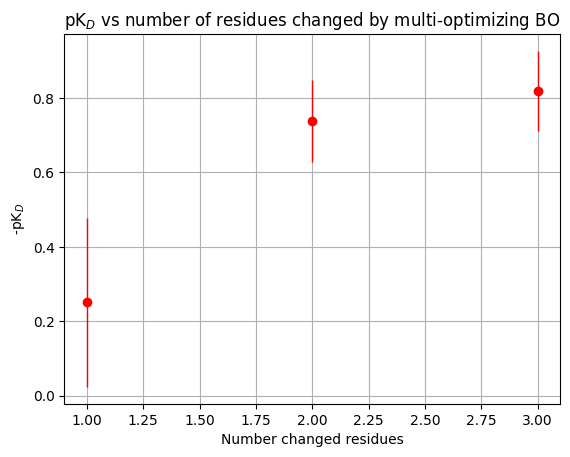

In [50]:
import copy
finfast = copy.deepcopy(final_fasta)
finsc = copy.deepcopy(final_score)
finmut = copy.deepcopy(mutations)
finscores = copy.deepcopy(scores)
import matplotlib.pyplot as plt
import pandas as pd
nchanges = [i+1 for i in range(len(finscores))]
avgsc=[]
stdsc = []
for nchange in scores:
    nonzeron = [1 if x!=0 else 0 for x in nchange]
    avgsc.append(sum(nchange)/sum(nonzeron))
    stdsc.append(pd.Series(nchange).std())
    


plt.errorbar(nchanges, avgsc, yerr=stdsc, fmt='o', color='red', ecolor='red', elinewidth=1, capsize=0)
plt.xlabel('Number changed residues')
plt.ylabel('-pK$_D$')
#plt.xlim(0,11)
plt.title(r'pK$_D$ vs number of residues changed by multi-optimizing BO')
plt.grid(True)

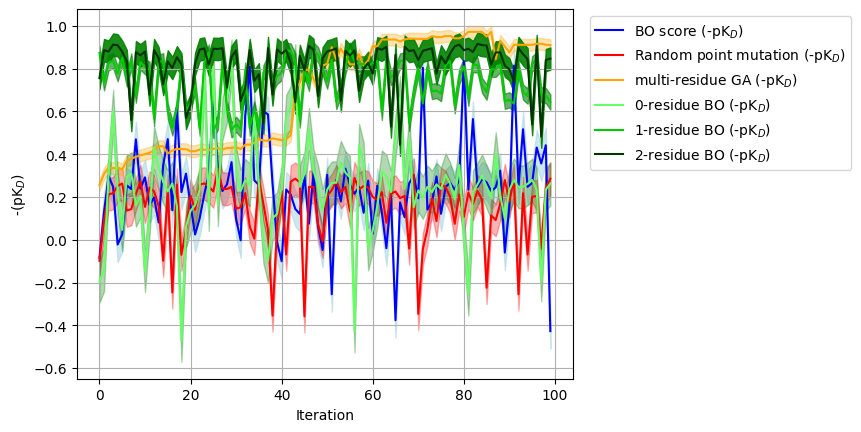

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def moving_average_std(data, window_size=5):
    """
    Calculate the moving average standard deviation of a time series data.
    
    Parameters:
        data (array-like): Time series data.
        window_size (int): Size of the moving window.
        
    Returns:
        pandas.Series: Average standard deviation as a function of time.
    """
    rolling_std = pd.Series(data).rolling(window=window_size, min_periods=1).std()
    return rolling_std

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

BO_vs_iter = [trial.objective_mean for trial in experiment.trials.values()]
avg_std = moving_average_std(BO_vs_iter, 5)
avg_stdRand = moving_average_std(rand_objectives, 5)
gascoresstd = moving_average_std(gascores,5)

plt.plot(BO_vs_iter, color='blue', label=r'BO score (-pK$_D$)')
#plt.plot(avg_std, color='blue', label='BO $\sigma$(pK$_D$)')
plt.fill_between(avg_std.index, BO_vs_iter - avg_std.std(), BO_vs_iter + avg_std.std(), color='lightblue', alpha=0.6,)

plt.plot(rand_objectives,color='red',label=r"Random point mutation (-pK$_D$)")
#plt.plot(avg_stdRand, color='red', label='random point mutation $\sigma$(pK$_D$)')
plt.fill_between(avg_std.index, rand_objectives - avg_stdRand.std(), rand_objectives + avg_stdRand.std(), color='red', alpha=0.3, )


avg_std = moving_average_std(gascores, 5)
gascoresstd = moving_average_std(gascores,5)
plt.plot(gascores,color='orange',label=r"multi-residue GA (-pK$_D$)")
plt.fill_between(avg_std.index, gascores - gascoresstd.std(), gascores + gascoresstd.std(), color='orange', alpha=0.3, )

for i in range(3):
    additiveBOscores = scores[i]
    additiveBOSTD = moving_average_std(additiveBOscores,5)
    plt.plot(additiveBOscores,color=lighten_color('green', 0.4*(i+1)),label=str(i)+r"-residue BO (-pK$_D$)")
    plt.fill_between(avg_std.index, additiveBOscores - additiveBOSTD.std(), additiveBOscores + additiveBOSTD.std(), color='green', alpha=0.3*(i+1), )

#plt.ylim(0)
plt.xlabel('Iteration')
plt.ylabel(r'-(pK$_D$)')
plt.title('')
plt.legend(bbox_to_anchor=(1.02, 1.0))
plt.grid(True)
plt.show()